In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import altair as alt

from PIL import Image
from skimage.transform import resize
from skimage.util import img_as_ubyte, img_as_float
from sklearn.metrics import pairwise_distances
from utils import set_up_environment, prewhiten, maximum_center_crop, l2_normalize
from plot.heatmap import heatmap, annotate_heatmap
from attacks.pgd import PGDAttacker

In [4]:
set_up_environment(visible_devices='0')

In [5]:
model_path = '../facenet_keras.h5'
model = tf.keras.models.load_model(model_path)

In [6]:
images = []
images_whitened = []
image_path = '../images/'
image_files = os.listdir(image_path)
image_files = [image_file for image_file in image_files if image_file.endswith('.png')]
for image_file in image_files:
    image = np.array(Image.open(os.path.join(image_path, image_file)))
    image = image[:, :, :3]
    image = maximum_center_crop(image)
    image = np.array(Image.fromarray(image).resize(size=(160, 160)))
    image = img_as_ubyte(image)
    image_whitened = prewhiten(image.astype(np.float32))

    images.append(image)
    images_whitened.append(image_whitened)

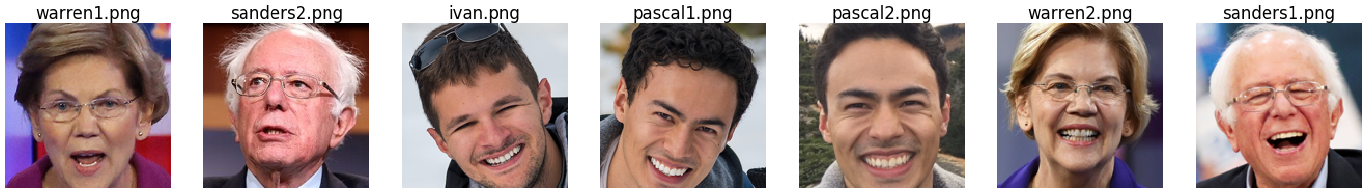

In [7]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(image_files[i], fontsize=24)
    axs[i].axis('off')

In [8]:
image_batch = tf.convert_to_tensor(np.array(images_whitened))

In [9]:
clean_embeddings = model.predict(image_batch)
clean_embeddings = l2_normalize(clean_embeddings)

In [10]:
attacker = PGDAttacker(model)

In [11]:
eps_vals = np.linspace(0.0, 0.5, 11)

In [12]:
perturbed_images = []
distance_arrays = []
for eps in eps_vals:
    perturbed_image_batch = attacker.self_distance_attack(image_batch, epsilon=eps)
    perturbed_images.append(perturbed_image_batch)

    perturbed_embeddings = model.predict(perturbed_image_batch)
    perturbed_embeddings = l2_normalize(perturbed_embeddings)

    distances = np.zeros(len(image_batch))
    for i in range(len(image_batch)):
        distances[i] = np.sqrt(np.sum(np.square(clean_embeddings[i] - perturbed_embeddings[i])))

    distance_arrays.append(distances)

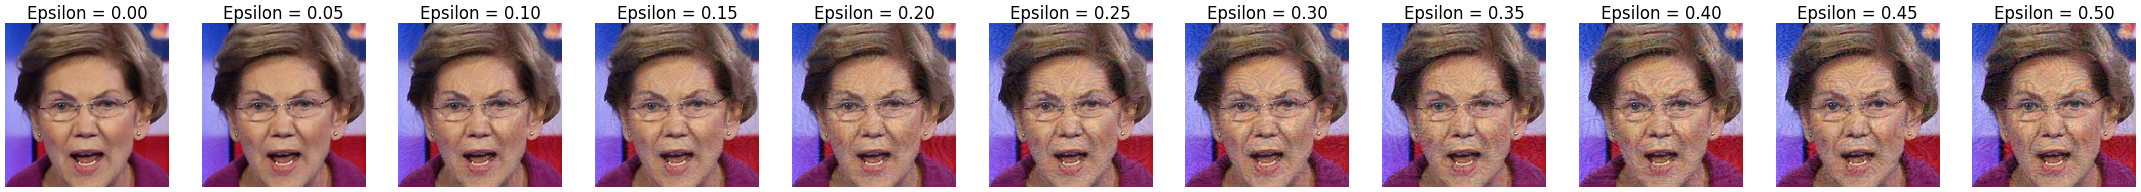

In [13]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(eps_vals), figsize=(5 * len(eps_vals), 5))
for i in range(len(eps_vals)):
    image = attacker._zero_one_norm(perturbed_images[i][0]).numpy()
    axs[i].imshow(image)
    axs[i].set_title('Epsilon = {:.2f}'.format(eps_vals[i]), fontsize=24)
    axs[i].axis('off')

In [14]:
data = pd.DataFrame(np.array(distance_arrays))
data['epsilon'] = eps_vals
data = pd.melt(data, var_name='face_id', value_name='self_distance', id_vars=['epsilon'])

In [15]:
line = alt.Chart(data).mark_line().encode(
    x='epsilon',
    y='mean(self_distance)'
)
band = alt.Chart(data).mark_errorband(extent='ci').encode(
    x='epsilon',
    y=alt.Y('self_distance', title='Self Distance'),
)
band + line

alt.LayerChart(...)

In [16]:
order = [1, 2, 3, 0, 5, 6, 4]
target_images = [images[i] for i in order]

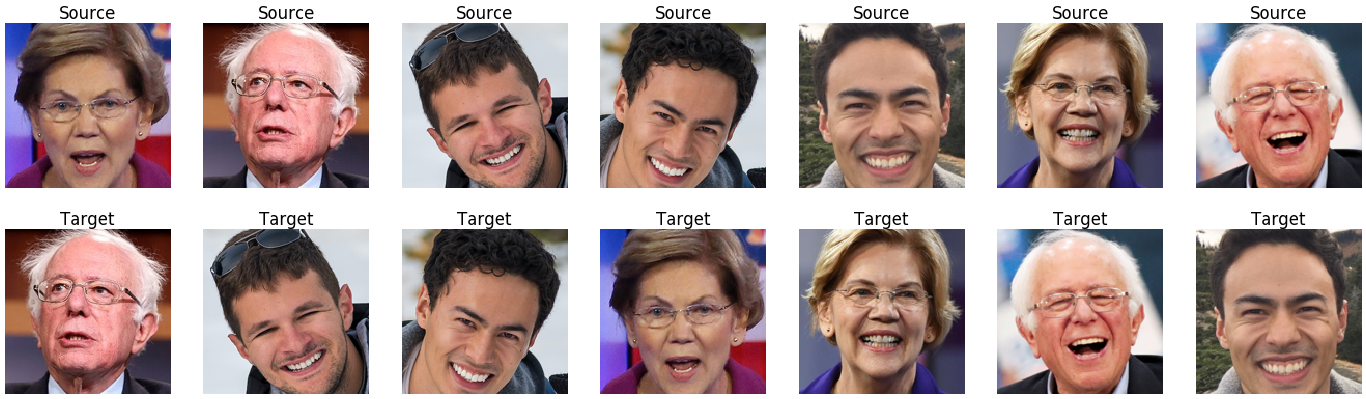

In [17]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(2, len(images), figsize=(5 * len(images), 10))
for i in range(len(images)):
    axs[0, i].imshow(images[i])
    axs[0, i].set_title('Source', fontsize=24)
    axs[0, i].axis('off')

    axs[1, i].imshow(target_images[i])
    axs[1, i].set_title('Target', fontsize=24)
    axs[1, i].axis('off')

In [18]:
targets_whitened = [prewhiten(image) for image in target_images]
target_batch = tf.convert_to_tensor(np.array(targets_whitened))

In [19]:
clean_embeddings = model.predict(image_batch)
clean_embeddings = l2_normalize(clean_embeddings)

In [20]:
target_embeddings = model.predict(target_batch)
target_embeddings = l2_normalize(target_embeddings)

In [23]:
perturbed_images = []
target_distance_arrays = []
self_distance_arrays = []

for eps in eps_vals:
    perturbed_image_batch = attacker.target_image_attack(image_batch, target_batch, epsilon=eps)
    perturbed_images.append(perturbed_image_batch)

    perturbed_embeddings = model.predict(perturbed_image_batch)
    perturbed_embeddings = l2_normalize(perturbed_embeddings)

    self_distances = np.zeros(len(image_batch))
    target_distances = np.zeros(len(image_batch))

    for i in range(len(image_batch)):
        self_distances[i]   = np.sqrt(np.sum(np.square(clean_embeddings[i]  - perturbed_embeddings[i])))
        target_distances[i] = np.sqrt(np.sum(np.square(target_embeddings[i] - perturbed_embeddings[i])))

    self_distance_arrays.append(self_distances)
    target_distance_arrays.append(target_distances)

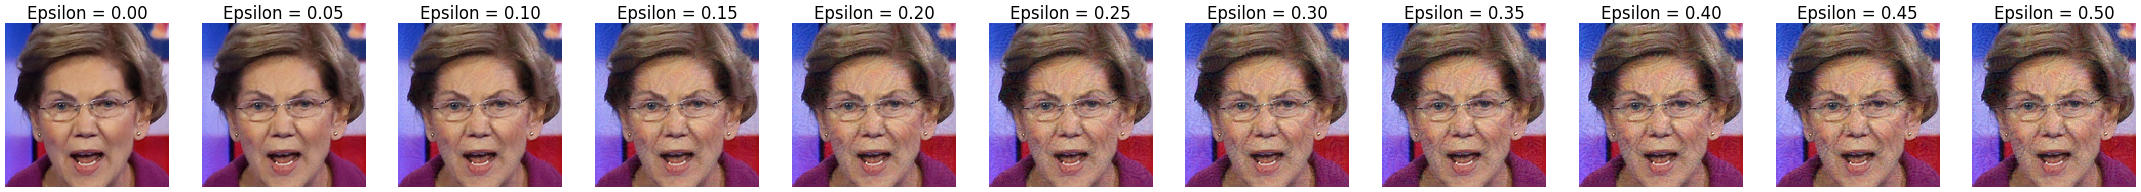

In [24]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(eps_vals), figsize=(5 * len(eps_vals), 5))
for i in range(len(eps_vals)):
    image = attacker._zero_one_norm(perturbed_images[i][0]).numpy()
    axs[i].imshow(image)
    axs[i].set_title('Epsilon = {:.2f}'.format(eps_vals[i]), fontsize=24)
    axs[i].axis('off')

In [25]:
self_distance_data = pd.DataFrame(np.array(self_distance_arrays))
self_distance_data['epsilon'] = eps_vals
self_distance_data = pd.melt(self_distance_data,
                             var_name='face_id',
                             value_name='self_distance',
                             id_vars=['epsilon'])

In [26]:
target_distance_data = pd.DataFrame(np.array(target_distance_arrays))
target_distance_data['epsilon'] = eps_vals
target_distance_data = pd.melt(target_distance_data,
                               var_name='face_id',
                               value_name='target_distance',
                               id_vars=['epsilon'])

In [27]:
line = alt.Chart(self_distance_data).mark_line().encode(
    x='epsilon',
    y='mean(self_distance)'
)
band = alt.Chart(self_distance_data).mark_errorband(extent='ci').encode(
    x='epsilon',
    y=alt.Y('self_distance', title='Self Distance'),
)
band + line

alt.LayerChart(...)

In [28]:
target_distance_data[target_distance_data['epsilon'] == 0.0]

,epsilon,face_id,target_distance
0,0.0,0,1.390291
11,0.0,1,1.431410
22,0.0,2,1.327106
33,0.0,3,1.246210
44,0.0,4,1.448380
55,0.0,5,1.397387
66,0.0,6,1.384381


In [29]:
line = alt.Chart(target_distance_data).mark_line().encode(
    x='epsilon',
    y='mean(target_distance)'
)
band = alt.Chart(target_distance_data).mark_errorband(extent='ci').encode(
    x='epsilon',
    y=alt.Y('target_distance', title='Target Distance'),
)
band + line

alt.LayerChart(...)